
## StyleSwin training on Trans-cerebellum plane images using pre-trained weights


**Author(s):** Zhanxiang (Sean) Sun [@seansunn](https://github.com/seansunn)

**Contributor(s):** Harvey Mannering [@harveymannering](https://github.com/harveymannering) and Miguel Xochicale [@mxochicale](https://github.com/mxochicale)


### Introduction
This notebook presents implementation of StyleSwin GAN model on the datasets for this project.

### Running notebook
Go to repository path: `cd $HOME/repositories/budai4medtech/midl2023/notebooks`   
Open repo in pycharm and in the terminal type:
```
git checkout master # or the branch
git pull # to bring a local branch up-to-date with its remote version
```
Launch Notebook server:
```
conda activate febusisVE
jupyter notebook --browser=firefox
```
which will open your web-browser.


### Logbook
* [DATE]: Short description of the update


### References

Bowen Zhang, Shuyang Gu, Bo Zhang, Jianmin Bao, Dong Chen, Fang Wen, Yong Wang, and Baining Guo. Styleswin: Transformer-based gan for high-resolution image generation. In *Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR)*, pages 11304–11314, June 2022.<br>
Official implementation: https://github.com/microsoft/StyleSwin<br>

Shengyu Zhao, Zhijian Liu, Ji Lin, Jun-Yan Zhu, and Song Han. Differentiable Augmentation for Data-Efficient GAN Training, June 2020.<br>
Official implementation: https://github.com/mit-han-lab/data-efficient-gans<br>

Liming Jiang, Bo Dai, Wayne Wu, and Chen Change Loy. Deceive D: Adaptive Pseudo Augmentation for GAN Training with Limited Data, 2021.<br>
Official implementation: https://github.com/EndlessSora/DeceiveD<br>





## 0. Setting imports and datasets paths


In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from model.dataset import getDataset, denormalize
from model.diffaug import DiffAugment
from model.generator import Generator
from model.discriminator import Discriminator
from torchmetrics.image.fid import FrechetInceptionDistance

%matplotlib inline
torch.manual_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
checkpoint_path = 'data/saved_tc_256_pre/'



## 1. Load datasets


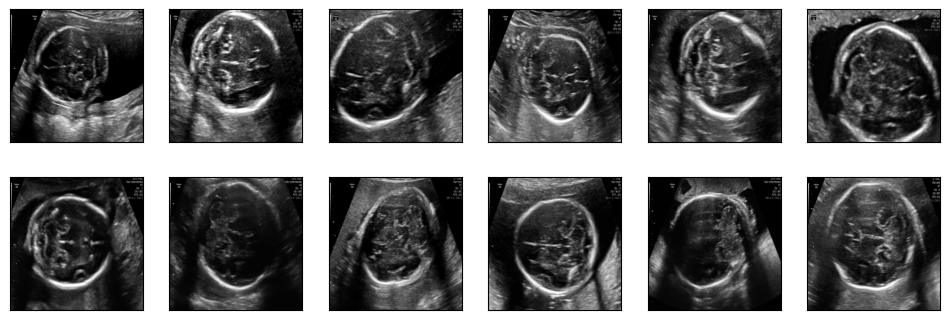

<Figure size 640x480 with 0 Axes>

In [2]:
# ['Trans-thalamic', 'Trans-cerebellum', 'Trans-ventricular']
brain_plane = 'Trans-cerebellum'
training_data = getDataset(brain_plane, size=256, show_img=True)


In [3]:
test_data = torch.load(f'data/images/test/{brain_plane}.pt', map_location=torch.device('cpu'))
test_len = len(test_data)
test_len


99


## 2. Define loss


In [4]:
def discriminator_loss(real_pred, fake_pred):
    real_loss = F.softplus(-real_pred)
    fake_loss = F.softplus(fake_pred)
    return real_loss.mean() + fake_loss.mean()


def generator_loss(fake_pred):
    return F.softplus(-fake_pred).mean()



## 3. Training loop setup



### 3.1 Initialize parameters for DiffAug and APA


In [5]:
# Diffaug policy
policy = "flip,color,translation"

# APA initializations
APA_p = 0.0
APA_threshold = 0.95
APA_speed = 1e-6
APA_update_step = 4
APA_start_epoch = 20
APA_max_prob = 0.6
lambda_r = 0.0



### 3.2 Setup training loop for one epoch


In [6]:
def generator_step(batch_size, latent_dim, policy=policy):
    """ One training step of the generator. """
    g_optimizer.zero_grad()
    generator.train()
    with torch.autocast(device_type='cuda', dtype=torch.float16):
        latent = torch.randn(batch_size, latent_dim).float().requires_grad_(False).to(device)
        fake_images = DiffAugment(generator(latent), policy=policy)
        d_fake = discriminator(fake_images)
        g_loss = generator_loss(d_fake)
    scaler.scale(g_loss).backward()
    scaler.step(g_optimizer)
    
    del fake_images
    
    return {'loss': g_loss}


def discriminator_step(batch_size, latent_dim, real_images, APA_p, policy=policy):
    """ One training step of the discriminator. """
    d_optimizer.zero_grad()
    with torch.autocast(device_type='cuda', dtype=torch.float16):
        latent = torch.randn(batch_size, latent_dim).float().requires_grad_(False).to(device)
        real_images = DiffAugment(real_images, policy=policy)
        with torch.no_grad():
            generator.eval()
            fake_images = DiffAugment(generator(latent), policy=policy)

            # implement APA
            num_mix_fakes = (torch.rand(batch_size) < APA_p).sum().item()
            if num_mix_fakes > 0:
                mix_latent = torch.randn(num_mix_fakes, latent_dim).float().requires_grad_(False).to(device)
                mix_fake_images = generator(mix_latent)
                real_images = torch.cat([real_images[:(batch_size - num_mix_fakes)], mix_fake_images])

        d_real = discriminator(real_images)
        d_fake = discriminator(fake_images.detach())
        d_loss = discriminator_loss(d_real, d_fake)
        
    scaler.scale(d_loss).backward()
    scaler.step(d_optimizer)
    
    # update lambda_r for APA
    if (epoch + 1) % APA_update_step == 0 and epoch >= APA_start_epoch:
        lambda_rs = []

        for d_r in d_real[:(batch_size - num_mix_fakes)]:
            _lambda_r = d_r.sign().mean().item()
            lambda_rs.append(_lambda_r)

        if len(lambda_rs) != 0:
            lambda_r = sum(lambda_rs) / len(lambda_rs)
            APA_p += np.sign(lambda_r - APA_threshold) * APA_speed * batch_size * APA_update_step
            APA_p = np.clip(APA_p, 0., APA_max_prob)
            
    scaler.update()
    
    return {'loss': d_loss}, APA_p



## 4. Hyperparameters, initialization, and helper functions


In [7]:
latent_dim = 512
n_epochs = 200
batch_size = 24
d_lr = 0.0002
g_lr = 0.00005
beta1 = 0.0
beta2 = 0.99


In [8]:
train_dataloader = DataLoader(training_data, batch_size, num_workers=4, shuffle=True, drop_last=True)
discriminator = Discriminator().to(device)
generator = Generator().to(device)
d_optimizer = torch.optim.Adam(discriminator.parameters(), d_lr, [beta1, beta2])
g_optimizer = torch.optim.Adam(generator.parameters(), g_lr, [beta1, beta2])
fid = FrechetInceptionDistance(feature=64).to('cpu')
scaler = torch.cuda.amp.GradScaler()


In [9]:
# load trained weights from plane Trans-thalamus
discriminator.load_state_dict(torch.load('data/saved_tt_256/d_500.pt'))
generator.load_state_dict(torch.load('data/saved_tt_256/g_500.pt'))


<All keys matched successfully>

In [10]:
def display(generated_images):
    """ helper function to display images during training """
    fig = plt.figure(figsize=(6, 4))
    plot_size = 3
    for idx in np.arange(plot_size):
        ax = fig.add_subplot(1, int(plot_size), idx+1, xticks=[], yticks=[])
        img = denormalize(generated_images[idx]).squeeze().detach().cpu().numpy()
        ax.imshow(img, cmap='gray')
    plt.show()
    plt.clf()


def expand_channel(x):
    # repeats channel for 3 times
    return x.repeat(1, 3, 1, 1)



## 5. Train the model


Epoch [  1/200] | D loss:  1.36 | G loss:  0.77 | P(apa): 0.00
Epoch [  2/200] | D loss:  1.42 | G loss:  0.66 | P(apa): 0.00
Epoch [  3/200] | D loss:  1.36 | G loss:  0.72 | P(apa): 0.00
Epoch [  4/200] | D loss:  1.45 | G loss:  0.73 | P(apa): 0.00
Epoch [  5/200] | D loss:  1.34 | G loss:  0.82 | P(apa): 0.00
Epoch [  6/200] | D loss:  1.34 | G loss:  0.76 | P(apa): 0.00
Epoch [  7/200] | D loss:  1.38 | G loss:  0.89 | P(apa): 0.00
Epoch [  8/200] | D loss:  1.36 | G loss:  0.76 | P(apa): 0.00
Epoch [  9/200] | D loss:  1.43 | G loss:  0.83 | P(apa): 0.00
Epoch [ 10/200] | D loss:  1.42 | G loss:  0.74 | P(apa): 0.00
Check point saved; FID: 37.187801361083984


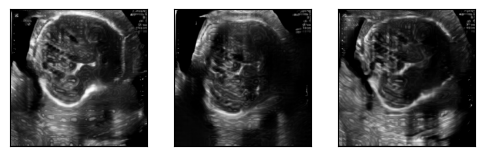

Epoch [ 11/200] | D loss:  1.40 | G loss:  0.69 | P(apa): 0.00
Epoch [ 12/200] | D loss:  1.38 | G loss:  0.70 | P(apa): 0.00
Epoch [ 13/200] | D loss:  1.36 | G loss:  0.81 | P(apa): 0.00
Epoch [ 14/200] | D loss:  1.36 | G loss:  0.79 | P(apa): 0.00
Epoch [ 15/200] | D loss:  1.35 | G loss:  0.68 | P(apa): 0.00
Epoch [ 16/200] | D loss:  1.38 | G loss:  0.77 | P(apa): 0.00
Epoch [ 17/200] | D loss:  1.32 | G loss:  0.65 | P(apa): 0.00
Epoch [ 18/200] | D loss:  1.40 | G loss:  0.91 | P(apa): 0.00
Epoch [ 19/200] | D loss:  1.35 | G loss:  0.69 | P(apa): 0.00
Epoch [ 20/200] | D loss:  1.36 | G loss:  0.76 | P(apa): 0.00
Check point saved; FID: 33.60457992553711


<Figure size 640x480 with 0 Axes>

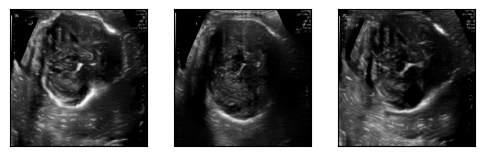

Epoch [ 21/200] | D loss:  1.42 | G loss:  0.70 | P(apa): 0.00
Epoch [ 22/200] | D loss:  1.33 | G loss:  0.74 | P(apa): 0.00
Epoch [ 23/200] | D loss:  1.38 | G loss:  0.73 | P(apa): 0.00
Epoch [ 24/200] | D loss:  1.36 | G loss:  0.87 | P(apa): 0.00
Epoch [ 25/200] | D loss:  1.39 | G loss:  0.74 | P(apa): 0.00
Epoch [ 26/200] | D loss:  1.40 | G loss:  0.78 | P(apa): 0.00
Epoch [ 27/200] | D loss:  1.45 | G loss:  0.62 | P(apa): 0.00
Epoch [ 28/200] | D loss:  1.30 | G loss:  0.80 | P(apa): 0.00
Epoch [ 29/200] | D loss:  1.37 | G loss:  0.71 | P(apa): 0.00
Epoch [ 30/200] | D loss:  1.37 | G loss:  0.88 | P(apa): 0.00
Check point saved; FID: 38.332794189453125


<Figure size 640x480 with 0 Axes>

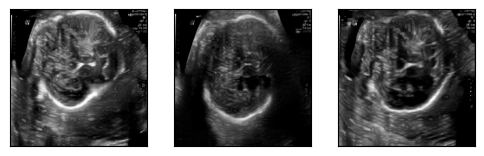

Epoch [ 31/200] | D loss:  1.40 | G loss:  0.76 | P(apa): 0.00
Epoch [ 32/200] | D loss:  1.39 | G loss:  0.74 | P(apa): 0.00
Epoch [ 33/200] | D loss:  1.38 | G loss:  0.68 | P(apa): 0.00
Epoch [ 34/200] | D loss:  1.36 | G loss:  0.71 | P(apa): 0.00
Epoch [ 35/200] | D loss:  1.31 | G loss:  0.83 | P(apa): 0.00
Epoch [ 36/200] | D loss:  1.36 | G loss:  0.71 | P(apa): 0.00
Epoch [ 37/200] | D loss:  1.32 | G loss:  0.82 | P(apa): 0.00
Epoch [ 38/200] | D loss:  1.40 | G loss:  0.68 | P(apa): 0.00
Epoch [ 39/200] | D loss:  1.35 | G loss:  0.70 | P(apa): 0.00
Epoch [ 40/200] | D loss:  1.46 | G loss:  0.71 | P(apa): 0.00
Check point saved; FID: 34.117149353027344


<Figure size 640x480 with 0 Axes>

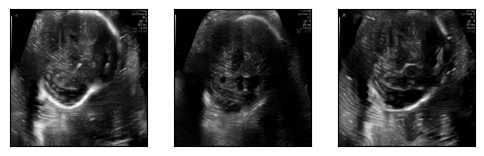

Epoch [ 41/200] | D loss:  1.30 | G loss:  0.76 | P(apa): 0.00
Epoch [ 42/200] | D loss:  1.41 | G loss:  0.70 | P(apa): 0.00
Epoch [ 43/200] | D loss:  1.37 | G loss:  0.75 | P(apa): 0.00
Epoch [ 44/200] | D loss:  1.38 | G loss:  0.69 | P(apa): 0.00
Epoch [ 45/200] | D loss:  1.35 | G loss:  0.73 | P(apa): 0.00
Epoch [ 46/200] | D loss:  1.39 | G loss:  0.71 | P(apa): 0.00
Epoch [ 47/200] | D loss:  1.38 | G loss:  0.70 | P(apa): 0.00
Epoch [ 48/200] | D loss:  1.39 | G loss:  0.73 | P(apa): 0.00
Epoch [ 49/200] | D loss:  1.48 | G loss:  0.77 | P(apa): 0.00
Epoch [ 50/200] | D loss:  1.32 | G loss:  0.80 | P(apa): 0.00
Check point saved; FID: 35.25444412231445


<Figure size 640x480 with 0 Axes>

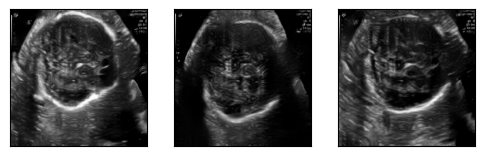

Epoch [ 51/200] | D loss:  1.31 | G loss:  0.69 | P(apa): 0.00
Epoch [ 52/200] | D loss:  1.38 | G loss:  0.78 | P(apa): 0.00
Epoch [ 53/200] | D loss:  1.36 | G loss:  0.75 | P(apa): 0.00
Epoch [ 54/200] | D loss:  1.36 | G loss:  0.83 | P(apa): 0.00
Epoch [ 55/200] | D loss:  1.39 | G loss:  0.83 | P(apa): 0.00
Epoch [ 56/200] | D loss:  1.40 | G loss:  0.80 | P(apa): 0.00
Epoch [ 57/200] | D loss:  1.39 | G loss:  0.73 | P(apa): 0.00
Epoch [ 58/200] | D loss:  1.37 | G loss:  0.71 | P(apa): 0.00
Epoch [ 59/200] | D loss:  1.33 | G loss:  0.75 | P(apa): 0.00
Epoch [ 60/200] | D loss:  1.32 | G loss:  0.80 | P(apa): 0.00
Check point saved; FID: 28.93021011352539


<Figure size 640x480 with 0 Axes>

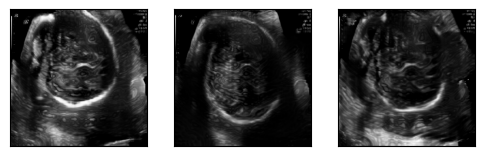

Epoch [ 61/200] | D loss:  1.40 | G loss:  0.62 | P(apa): 0.00
Epoch [ 62/200] | D loss:  1.42 | G loss:  0.88 | P(apa): 0.00
Epoch [ 63/200] | D loss:  1.33 | G loss:  0.74 | P(apa): 0.00
Epoch [ 64/200] | D loss:  1.37 | G loss:  0.79 | P(apa): 0.00
Epoch [ 65/200] | D loss:  1.37 | G loss:  0.77 | P(apa): 0.00
Epoch [ 66/200] | D loss:  1.36 | G loss:  0.73 | P(apa): 0.00
Epoch [ 67/200] | D loss:  1.41 | G loss:  0.77 | P(apa): 0.00
Epoch [ 68/200] | D loss:  1.37 | G loss:  0.76 | P(apa): 0.00
Epoch [ 69/200] | D loss:  1.39 | G loss:  0.72 | P(apa): 0.00
Epoch [ 70/200] | D loss:  1.35 | G loss:  0.70 | P(apa): 0.00
Check point saved; FID: 33.872005462646484


<Figure size 640x480 with 0 Axes>

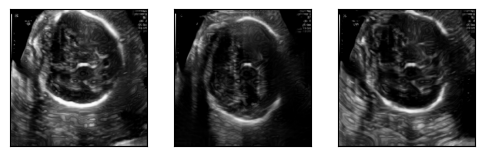

Epoch [ 71/200] | D loss:  1.47 | G loss:  0.81 | P(apa): 0.00
Epoch [ 72/200] | D loss:  1.33 | G loss:  0.71 | P(apa): 0.00
Epoch [ 73/200] | D loss:  1.39 | G loss:  0.72 | P(apa): 0.00
Epoch [ 74/200] | D loss:  1.36 | G loss:  0.67 | P(apa): 0.00
Epoch [ 75/200] | D loss:  1.33 | G loss:  0.73 | P(apa): 0.00
Epoch [ 76/200] | D loss:  1.35 | G loss:  0.89 | P(apa): 0.00
Epoch [ 77/200] | D loss:  1.35 | G loss:  0.62 | P(apa): 0.00
Epoch [ 78/200] | D loss:  1.34 | G loss:  0.67 | P(apa): 0.00
Epoch [ 79/200] | D loss:  1.42 | G loss:  0.73 | P(apa): 0.00
Epoch [ 80/200] | D loss:  1.36 | G loss:  0.65 | P(apa): 0.00
Check point saved; FID: 41.98368835449219


<Figure size 640x480 with 0 Axes>

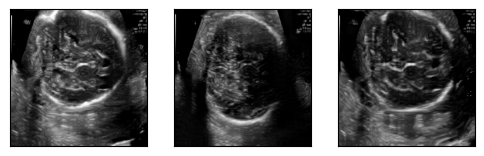

Epoch [ 81/200] | D loss:  1.32 | G loss:  0.66 | P(apa): 0.00
Epoch [ 82/200] | D loss:  1.39 | G loss:  0.95 | P(apa): 0.00
Epoch [ 83/200] | D loss:  1.36 | G loss:  0.72 | P(apa): 0.00
Epoch [ 84/200] | D loss:  1.34 | G loss:  0.73 | P(apa): 0.00
Epoch [ 85/200] | D loss:  1.29 | G loss:  0.72 | P(apa): 0.00
Epoch [ 86/200] | D loss:  1.37 | G loss:  0.76 | P(apa): 0.00
Epoch [ 87/200] | D loss:  1.34 | G loss:  0.73 | P(apa): 0.00
Epoch [ 88/200] | D loss:  1.33 | G loss:  0.72 | P(apa): 0.00
Epoch [ 89/200] | D loss:  1.40 | G loss:  0.71 | P(apa): 0.00
Epoch [ 90/200] | D loss:  1.32 | G loss:  0.76 | P(apa): 0.00
Check point saved; FID: 41.515811920166016


<Figure size 640x480 with 0 Axes>

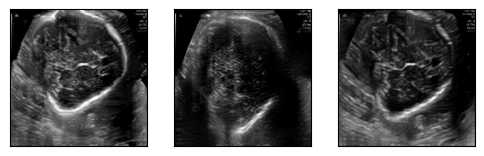

Epoch [ 91/200] | D loss:  1.37 | G loss:  0.74 | P(apa): 0.00
Epoch [ 92/200] | D loss:  1.40 | G loss:  0.71 | P(apa): 0.00
Epoch [ 93/200] | D loss:  1.38 | G loss:  0.73 | P(apa): 0.00
Epoch [ 94/200] | D loss:  1.35 | G loss:  0.76 | P(apa): 0.00
Epoch [ 95/200] | D loss:  1.33 | G loss:  0.78 | P(apa): 0.00
Epoch [ 96/200] | D loss:  1.41 | G loss:  0.72 | P(apa): 0.00
Epoch [ 97/200] | D loss:  1.41 | G loss:  0.68 | P(apa): 0.00
Epoch [ 98/200] | D loss:  1.34 | G loss:  0.81 | P(apa): 0.00
Epoch [ 99/200] | D loss:  1.33 | G loss:  0.85 | P(apa): 0.00
Epoch [100/200] | D loss:  1.38 | G loss:  0.62 | P(apa): 0.00
Check point saved; FID: 36.993743896484375


<Figure size 640x480 with 0 Axes>

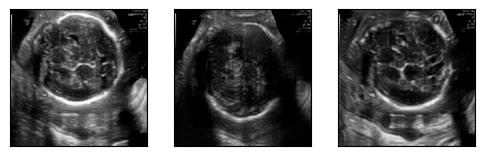

Epoch [101/200] | D loss:  1.39 | G loss:  0.85 | P(apa): 0.00
Epoch [102/200] | D loss:  1.38 | G loss:  0.76 | P(apa): 0.00
Epoch [103/200] | D loss:  1.41 | G loss:  0.81 | P(apa): 0.00
Epoch [104/200] | D loss:  1.39 | G loss:  0.64 | P(apa): 0.00
Epoch [105/200] | D loss:  1.36 | G loss:  0.73 | P(apa): 0.00
Epoch [106/200] | D loss:  1.30 | G loss:  0.74 | P(apa): 0.00
Epoch [107/200] | D loss:  1.43 | G loss:  0.80 | P(apa): 0.00
Epoch [108/200] | D loss:  1.46 | G loss:  0.82 | P(apa): 0.00
Epoch [109/200] | D loss:  1.42 | G loss:  0.76 | P(apa): 0.00
Epoch [110/200] | D loss:  1.39 | G loss:  0.63 | P(apa): 0.00
Check point saved; FID: 35.89326095581055


<Figure size 640x480 with 0 Axes>

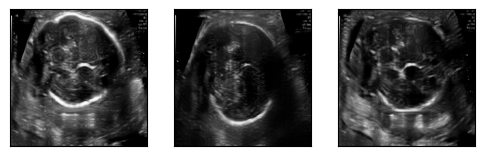

Epoch [111/200] | D loss:  1.37 | G loss:  0.75 | P(apa): 0.00
Epoch [112/200] | D loss:  1.38 | G loss:  0.76 | P(apa): 0.00
Epoch [113/200] | D loss:  1.37 | G loss:  0.74 | P(apa): 0.00
Epoch [114/200] | D loss:  1.41 | G loss:  0.83 | P(apa): 0.00
Epoch [115/200] | D loss:  1.42 | G loss:  0.69 | P(apa): 0.00
Epoch [116/200] | D loss:  1.35 | G loss:  0.75 | P(apa): 0.00
Epoch [117/200] | D loss:  1.35 | G loss:  0.68 | P(apa): 0.00
Epoch [118/200] | D loss:  1.40 | G loss:  0.65 | P(apa): 0.00
Epoch [119/200] | D loss:  1.30 | G loss:  0.67 | P(apa): 0.00
Epoch [120/200] | D loss:  1.31 | G loss:  0.78 | P(apa): 0.00
Check point saved; FID: 34.8416862487793


<Figure size 640x480 with 0 Axes>

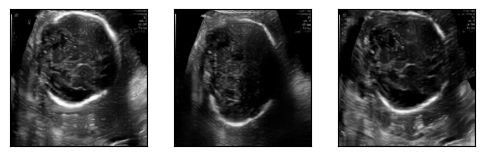

Epoch [121/200] | D loss:  1.41 | G loss:  0.68 | P(apa): 0.00
Epoch [122/200] | D loss:  1.34 | G loss:  0.81 | P(apa): 0.00
Epoch [123/200] | D loss:  1.32 | G loss:  0.70 | P(apa): 0.00
Epoch [124/200] | D loss:  1.34 | G loss:  0.88 | P(apa): 0.00
Epoch [125/200] | D loss:  1.33 | G loss:  0.75 | P(apa): 0.00
Epoch [126/200] | D loss:  1.37 | G loss:  0.87 | P(apa): 0.00
Epoch [127/200] | D loss:  1.38 | G loss:  0.71 | P(apa): 0.00
Epoch [128/200] | D loss:  1.35 | G loss:  0.83 | P(apa): 0.00
Epoch [129/200] | D loss:  1.32 | G loss:  0.87 | P(apa): 0.00
Epoch [130/200] | D loss:  1.41 | G loss:  0.76 | P(apa): 0.00
Check point saved; FID: 34.75127029418945


<Figure size 640x480 with 0 Axes>

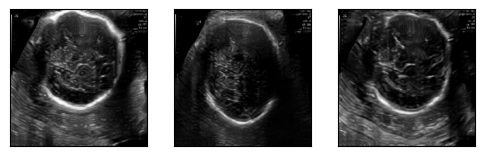

Epoch [131/200] | D loss:  1.38 | G loss:  0.73 | P(apa): 0.00
Epoch [132/200] | D loss:  1.34 | G loss:  0.79 | P(apa): 0.00
Epoch [133/200] | D loss:  1.42 | G loss:  0.78 | P(apa): 0.00
Epoch [134/200] | D loss:  1.29 | G loss:  0.76 | P(apa): 0.00
Epoch [135/200] | D loss:  1.32 | G loss:  0.77 | P(apa): 0.00
Epoch [136/200] | D loss:  1.37 | G loss:  0.72 | P(apa): 0.00
Epoch [137/200] | D loss:  1.33 | G loss:  0.75 | P(apa): 0.00
Epoch [138/200] | D loss:  1.35 | G loss:  0.69 | P(apa): 0.00
Epoch [139/200] | D loss:  1.45 | G loss:  0.81 | P(apa): 0.00
Epoch [140/200] | D loss:  1.43 | G loss:  0.73 | P(apa): 0.00
Check point saved; FID: 33.86090087890625


<Figure size 640x480 with 0 Axes>

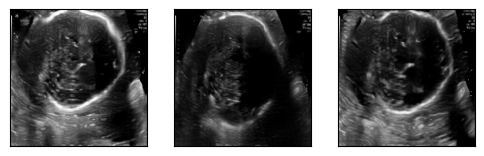

Epoch [141/200] | D loss:  1.36 | G loss:  0.61 | P(apa): 0.00
Epoch [142/200] | D loss:  1.36 | G loss:  0.91 | P(apa): 0.00
Epoch [143/200] | D loss:  1.24 | G loss:  0.73 | P(apa): 0.00
Epoch [144/200] | D loss:  1.43 | G loss:  0.71 | P(apa): 0.00
Epoch [145/200] | D loss:  1.36 | G loss:  0.80 | P(apa): 0.00
Epoch [146/200] | D loss:  1.27 | G loss:  0.75 | P(apa): 0.00
Epoch [147/200] | D loss:  1.39 | G loss:  0.74 | P(apa): 0.00
Epoch [148/200] | D loss:  1.35 | G loss:  0.67 | P(apa): 0.00
Epoch [149/200] | D loss:  1.38 | G loss:  0.79 | P(apa): 0.00
Epoch [150/200] | D loss:  1.35 | G loss:  0.73 | P(apa): 0.00
Check point saved; FID: 35.044063568115234


<Figure size 640x480 with 0 Axes>

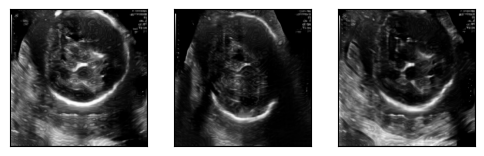

Epoch [151/200] | D loss:  1.33 | G loss:  0.71 | P(apa): 0.00
Epoch [152/200] | D loss:  1.31 | G loss:  0.75 | P(apa): 0.00
Epoch [153/200] | D loss:  1.31 | G loss:  0.70 | P(apa): 0.00
Epoch [154/200] | D loss:  1.36 | G loss:  0.69 | P(apa): 0.00
Epoch [155/200] | D loss:  1.41 | G loss:  0.86 | P(apa): 0.00
Epoch [156/200] | D loss:  1.33 | G loss:  0.79 | P(apa): 0.00
Epoch [157/200] | D loss:  1.44 | G loss:  0.93 | P(apa): 0.00
Epoch [158/200] | D loss:  1.35 | G loss:  0.71 | P(apa): 0.00
Epoch [159/200] | D loss:  1.43 | G loss:  0.75 | P(apa): 0.00
Epoch [160/200] | D loss:  1.29 | G loss:  0.68 | P(apa): 0.00
Check point saved; FID: 38.50218200683594


<Figure size 640x480 with 0 Axes>

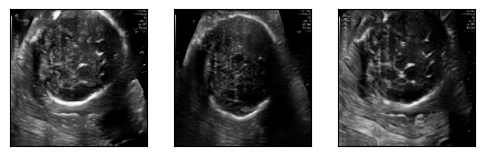

Epoch [161/200] | D loss:  1.37 | G loss:  0.70 | P(apa): 0.00
Epoch [162/200] | D loss:  1.45 | G loss:  0.82 | P(apa): 0.00
Epoch [163/200] | D loss:  1.35 | G loss:  0.79 | P(apa): 0.00
Epoch [164/200] | D loss:  1.35 | G loss:  0.84 | P(apa): 0.00
Epoch [165/200] | D loss:  1.35 | G loss:  0.71 | P(apa): 0.00
Epoch [166/200] | D loss:  1.30 | G loss:  0.82 | P(apa): 0.00
Epoch [167/200] | D loss:  1.27 | G loss:  0.71 | P(apa): 0.00
Epoch [168/200] | D loss:  1.27 | G loss:  0.78 | P(apa): 0.00
Epoch [169/200] | D loss:  1.37 | G loss:  0.71 | P(apa): 0.00
Epoch [170/200] | D loss:  1.36 | G loss:  0.81 | P(apa): 0.00
Check point saved; FID: 33.2642822265625


<Figure size 640x480 with 0 Axes>

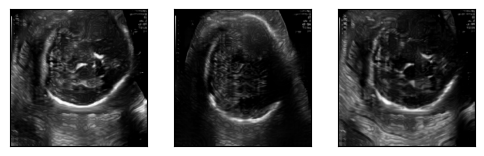

Epoch [171/200] | D loss:  1.36 | G loss:  0.62 | P(apa): 0.00
Epoch [172/200] | D loss:  1.38 | G loss:  0.80 | P(apa): 0.00
Epoch [173/200] | D loss:  1.34 | G loss:  0.75 | P(apa): 0.00
Epoch [174/200] | D loss:  1.28 | G loss:  0.77 | P(apa): 0.00
Epoch [175/200] | D loss:  1.35 | G loss:  0.78 | P(apa): 0.00
Epoch [176/200] | D loss:  1.35 | G loss:  0.61 | P(apa): 0.00
Epoch [177/200] | D loss:  1.35 | G loss:  0.97 | P(apa): 0.00
Epoch [178/200] | D loss:  1.41 | G loss:  0.71 | P(apa): 0.00
Epoch [179/200] | D loss:  1.36 | G loss:  0.68 | P(apa): 0.00
Epoch [180/200] | D loss:  1.42 | G loss:  0.80 | P(apa): 0.00
Check point saved; FID: 35.31943130493164


<Figure size 640x480 with 0 Axes>

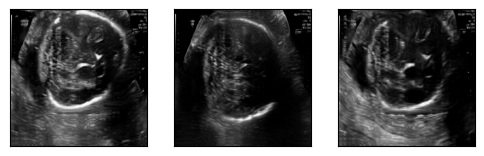

Epoch [181/200] | D loss:  1.32 | G loss:  0.65 | P(apa): 0.00
Epoch [182/200] | D loss:  1.34 | G loss:  0.70 | P(apa): 0.00
Epoch [183/200] | D loss:  1.34 | G loss:  0.83 | P(apa): 0.00
Epoch [184/200] | D loss:  1.31 | G loss:  0.79 | P(apa): 0.00
Epoch [185/200] | D loss:  1.32 | G loss:  0.80 | P(apa): 0.00
Epoch [186/200] | D loss:  1.41 | G loss:  0.76 | P(apa): 0.00
Epoch [187/200] | D loss:  1.39 | G loss:  0.65 | P(apa): 0.00
Epoch [188/200] | D loss:  1.40 | G loss:  0.72 | P(apa): 0.00
Epoch [189/200] | D loss:  1.37 | G loss:  0.76 | P(apa): 0.00
Epoch [190/200] | D loss:  1.32 | G loss:  0.63 | P(apa): 0.00
Check point saved; FID: 42.50156021118164


<Figure size 640x480 with 0 Axes>

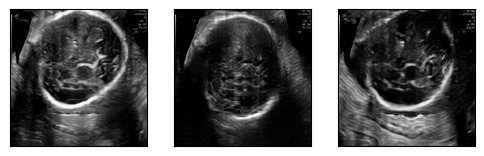

Epoch [191/200] | D loss:  1.41 | G loss:  0.73 | P(apa): 0.00
Epoch [192/200] | D loss:  1.40 | G loss:  0.75 | P(apa): 0.00
Epoch [193/200] | D loss:  1.34 | G loss:  0.75 | P(apa): 0.00
Epoch [194/200] | D loss:  1.33 | G loss:  0.75 | P(apa): 0.00
Epoch [195/200] | D loss:  1.38 | G loss:  0.75 | P(apa): 0.00
Epoch [196/200] | D loss:  1.30 | G loss:  0.81 | P(apa): 0.00
Epoch [197/200] | D loss:  1.41 | G loss:  0.77 | P(apa): 0.00
Epoch [198/200] | D loss:  1.31 | G loss:  0.78 | P(apa): 0.00
Epoch [199/200] | D loss:  1.33 | G loss:  0.81 | P(apa): 0.00
Epoch [200/200] | D loss:  1.30 | G loss:  0.83 | P(apa): 0.00
Check point saved; FID: 34.6334114074707


<Figure size 640x480 with 0 Axes>

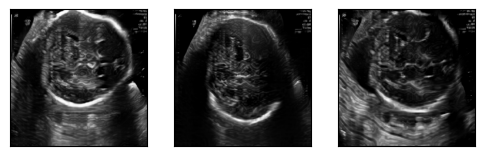

<Figure size 640x480 with 0 Axes>

In [11]:
fixed_latent_vector = torch.randn(3, latent_dim).float().to(device)
fixed_FID_vector = torch.randn(test_len, latent_dim).float().to(device)

losses = []
fids = []

discriminator.train()
generator.train()

for epoch in range(n_epochs):
    for i, real_images in enumerate(train_dataloader):
        real_images = real_images.to(device)

        d_loss, APA_p = discriminator_step(batch_size, latent_dim, real_images, APA_p)
        g_loss = generator_step(batch_size, latent_dim)

    d = d_loss['loss'].item()
    g = g_loss['loss'].item()
    losses.append((d, g))
    

    # print discriminator and generator loss
    print(f'Epoch [{epoch+1:3}/{n_epochs}] | D loss: {d:5.2f} | G loss: {g:5.2f} | P(apa): {APA_p:.2f}')
    
    if (epoch+1) % 10 == 0:
        generator.eval()
        with torch.no_grad():
            fid_img_list = []
            for i in range(test_len):
                fid_img = denormalize(generator(fixed_FID_vector[i].unsqueeze(0))).detach().cpu()
                fid_img_list.append(fid_img)

            fid_cat = torch.cat(fid_img_list)
            fid.update(test_data, real=True)
            fid.update(expand_channel(fid_cat), real=False)
            current_fid = fid.compute().item()
            fids.append(current_fid)
            fid.reset()
            
            # save checpoint
            torch.save(discriminator.state_dict(), checkpoint_path+f'd_{epoch+1:03}.pt')
            torch.save(generator.state_dict(), checkpoint_path+f'g_{epoch+1:03}.pt')
            print(f'Check point saved; FID: {current_fid}')

            # display images during training
            generated_images = generator(fixed_latent_vector)
            display(generated_images)
            del generated_images
 


## 6. Plot losses and FIDs



### 6.1 Training losses


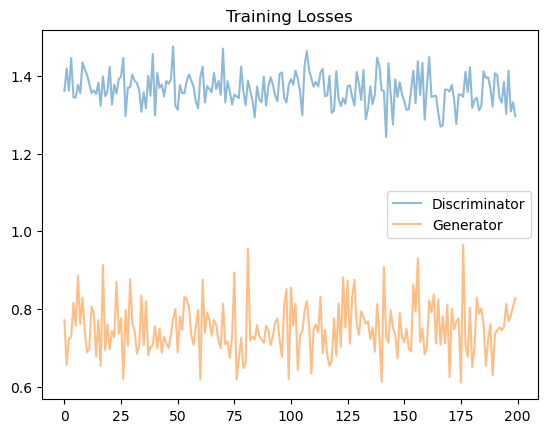

In [12]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()



### 6.2 FIDs


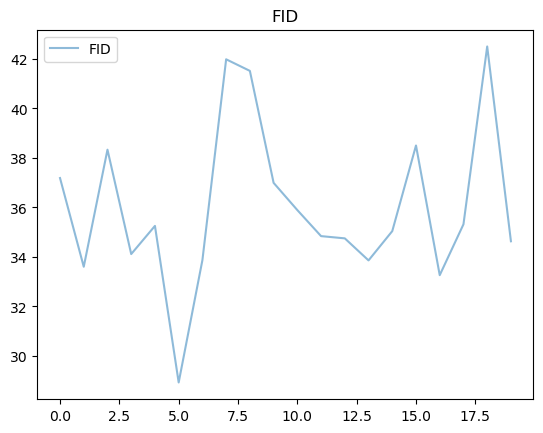

In [13]:
fig, ax = plt.subplots()
plt.plot(fids, label='FID', alpha=0.5)
plt.title("FID")
plt.legend()



### 6.3 Export logs


In [14]:
import numpy as np


D_loss_log = losses.T[0]
G_loss_log = losses.T[1]
fid_log = np.array(fids)
np.save('logs/tc_200_2_D_loss_log.npy', D_loss_log)
np.save('logs/tc_200_2_G_loss_log.npy', G_loss_log)
np.save('logs/tc_200_2_FID_log.npy', fid_log)
